In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
using LinearAlgebra, Plots, ControlSystems

  Activating project at `C:\Users\lingy\Documents\MRAC_LQR`


In [79]:
"
    系统参数
"
J_nominal = 7.23e-4       # 标称转动惯量 (kg·m²)
b = 0.1 #阻尼系数
@show J_nominal
dt = 0.02            # 采样时间 (s)

J_nominal = 0.000723


0.02

In [80]:
"
    参考系统
"
A = [0 1; 0 0]
B = [0; 1/J_nominal]
C = I(2)
D = zeros(2,1)
sys_cont = ss(A, B, C, D)
sys_dis = c2d(sys_cont, dt, :zoh)

# LQR权重矩阵
Q = diagm([50000.0, 100.0])  # 状态权重 [角度, 角速度]
R = diagm([0.01])               # 控制输入权重
K_nominal = dlqr(sys_dis.A, sys_dis.B, Q, R)

1×2 Matrix{Float64}:
 0.660619  0.0427562

In [81]:
"
    李雅普诺夫
"
Am = sys_dis.A
Bm = sys_dis.B

Am_lqr = Am - Bm * K_nominal  #参考系统

P = dlyap(Am_lqr', I(2))

2×2 Matrix{Float64}:
 561.135    5.60135
   5.60135  1.05601

In [103]:
"
    仿真初始化
"
#仿真时间配置
sim_time = 10.0         # 总仿真时间 (s)
t_steps = 0:dt:sim_time
N = length(t_steps)

θ = 60.0  #期望角度
θd_rad = deg2rad(θ)
θ_sin(t) = sin(2*t)

# J_real(t) = t < 0.04 ? J_nominal : J_nominal*5  # 惯量突变
J_real(t) = J_nominal*5(1.01+sin(2*t))  # 时变实际惯量

Γx = 5e-3  #自适应控制率调节参数

x_m = zeros(2, N)   #参考模型状态
x = zeros(2, N)     #实际模型状态
x_f = zeros(2, N)   #实际模型状态(无自适应)

e_hist = zeros(2, N)   #跟踪误差
ef_hist = zeros(2, N)  #跟踪误差(无自适应)

B_hist = zeros(2, N)   #实际模型输入参数
B_nor = zeros(2, N)    #参考模型输入参数

Kad_hist = zeros(N, 2)  #自适应LQR增益
Km_hist = zeros(N, 2)   #参考模型LQR增益
ΔK_hist = zeros(N, 2)   #自适应LQR增益变化率

x_des = [θd_rad; 0.0]   #期望状态
xd_hist = zeros(2, N)   #期望状态

x_m[:, 1] = [0.0; 0.0]  #当前时刻状态
x[:, 1] = [0.0; 0.0]
Kx = K_nominal'     #自适应LQR增益

2×1 adjoint(::Matrix{Float64}) with eltype Float64:
 0.6606194680048213
 0.0427561915247147

In [104]:
#仿真
for i in 1:N-1
    
    t = t_steps[i]

    #期望状态更新
    # x_des = [θd_rad; 0.0]      #阶跃
    x_des = [θ_sin(t); 0.0]  #时变
    
    
    #转动惯量发生变化
    current_J = J_real(t)
    #实际模型更新
    A_plant = [0.0 1.0; 0.0 -b/current_J]
    B_plant = [0.0; 1/current_J]
    C_plant = C
    D_plant = D
    sys_plant_cont = ss(A_plant, B_plant, C_plant, D_plant)
    sys_plant_dis = c2d(sys_plant_cont, dt, :zoh)
    A_plant_dis = sys_plant_dis.A
    B_plant_dis = sys_plant_dis.B

    #计算前馈
    # uff = (pinv(I-Am)*Bm)\(x_des)    #计算伪逆求解
    
    M = [(Am-I) Bm; [1 0 0]]  #构造约束矩阵求解(可能速度更快)
    S = [0;0;x_des[1]]
    uff = (M\S)[3]
    
    #参考信号  即LQR计算得到的输入
    # u_r = K_nominal * x_des   #不带前馈

    u_r = uff .+ K_nominal * x_des  #带前馈
    
    #更新参考输出 C=I,y=x
    x_m[:, i+1] = Am_lqr * x_m[:, i] + Bm * u_r

    #真实系统的输入信号
    u_f = -K_nominal * (x_f[:, i] - x_des)  #对比试验，使用原增益给真实系统
    u = -Kx'*(x[:, i] - x_des)  #通过自适应调节的增益给真实系统
    
    #更新真实输出 C=I,y=x
    x[:, i+1] = A_plant_dis * x[:, i] + B_plant_dis * u
    #对比试验
    x_f[:, i+1] = A_plant_dis * x_f[:, i] + B_plant_dis * u_f
    
    e = x[:, i] - x_m[:, i]
    e_f = x_f[:, i] - x_m[:, i]
    
    #更新自适应率
    K̇x = Γx.*x[:, i]*e'*P*B_plant_dis
    Kx += K̇x.*dt   #前向欧拉法积分(可以换成RK4)

    #轨迹更新
    e_hist[:, i] = e
    ef_hist[:, i] = e_f
    xd_hist[: ,i] = x_des
    B_hist[:, i] = B_plant_dis
    B_nor[:, i] = Bm
    Kad_hist[i, :] = Kx'
    Km_hist[i, :] = K_nominal
    ΔK_hist[i, :] = K̇x'
    
end

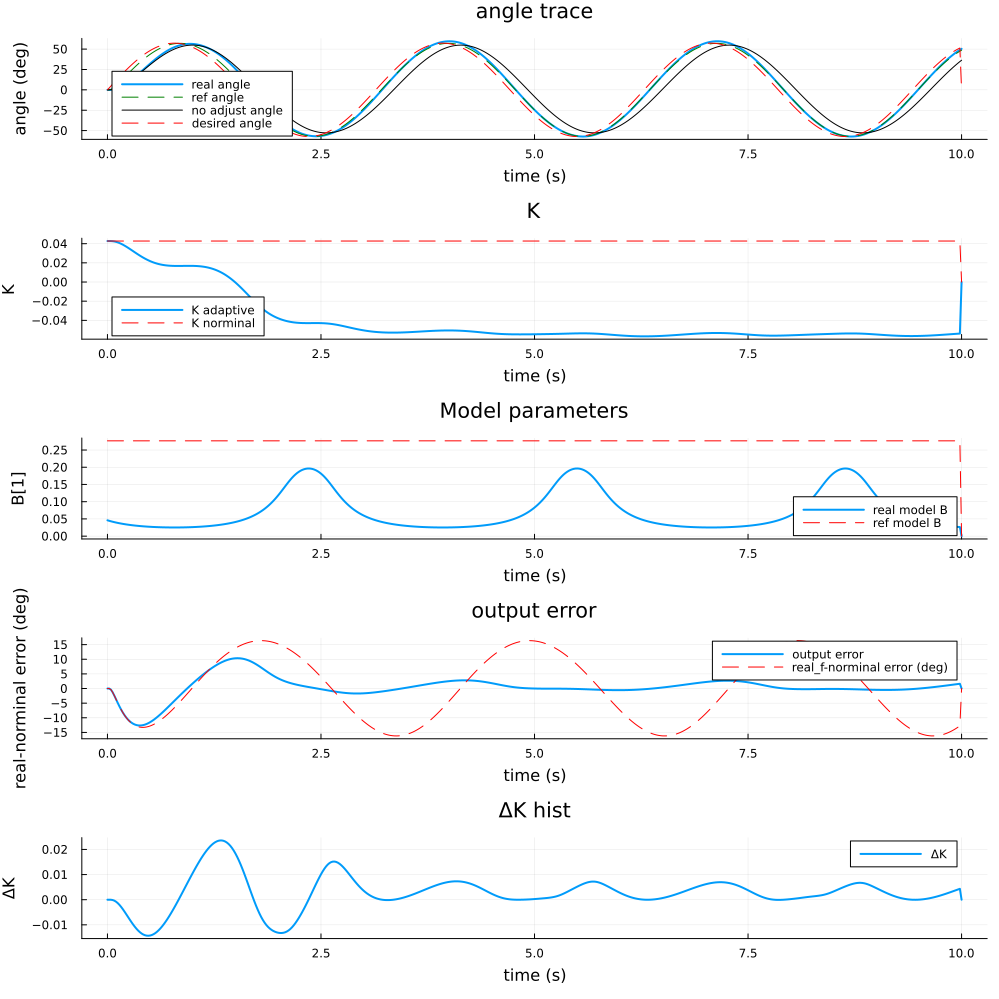

In [106]:
"
    显示仿真结果
"
p1 = plot(t_steps, rad2deg.(x[1,:]), 
         label="real angle", 
         linewidth=2,
         xlabel="time (s)", 
         ylabel="angle (deg)",
         title="angle trace")
plot!(t_steps, rad2deg.(x_m[1,:]), label="ref angle", ls=:dash,linecolor=:green)
plot!(t_steps, rad2deg.(x_f[1,:]), label="no adjust angle",linecolor=:black)
plot!(t_steps, rad2deg.(xd_hist[1,:]), label="desired angle",ls=:dash,linecolor=:red)

# 自适应LQR增益
p2 = plot(t_steps, Kad_hist[:,2], 
         label="K adaptive", 
         linewidth=2,
         xlabel="time (s)", 
         ylabel="K",
        title="K")
plot!(t_steps, Km_hist[:,2], label="K norminal", ls=:dash,linecolor=:red)

# 模型参数
p3 = plot(t_steps, B_hist[1,:], 
         label="real model B", 
         linewidth=2,
         xlabel="time (s)", 
         ylabel="B[1]",
         title="Model parameters")
plot!(t_steps, B_nor[1,:], label="ref model B", ls=:dash,linecolor=:red)

#模型跟踪误差
p4 = plot(t_steps, rad2deg.(e_hist[1,:]), 
         label="output error", 
         linewidth=2,
         xlabel="time (s)", 
         ylabel="real-norminal error (deg)",
         title="output error")
plot!(t_steps, rad2deg.(ef_hist[1,:]), label="real_f-norminal error (deg)", ls=:dash,linecolor=:red)

# 自适应LQR增益变化率
p5 = plot(t_steps, ΔK_hist[:,1], 
         label="ΔK", 
         linewidth=2,
         xlabel="time (s)", 
         ylabel="ΔK",
        title="ΔK hist")

plot(p1, p2, p3, p4, p5, layout=(5,1), size=(1000,1000))